In [5]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import matplotlib.pyplot as plt
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OmNjN2M0YzRjMjNhZjQ1Zjc3NzZiODI4MmNjMjc4Njgw'


In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
security_api = intrinio_sdk.SecurityApi()

identifier = 'MSFT' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = '2010-01-01' # date | Return prices on or after the date (optional)
end_date = '2020-08-11' # date | Return prices on or before the date (optional)
frequency = 'daily' # str | Return stock prices in the given frequency (optional) (default to daily)
page_size = 3000 # int | The number of results to return (optional) (default to 100)
next_page = '' # str | Gets the next page of data from a previous API call (optional)

try:
  api_response = security_api.get_security_stock_prices(identifier, start_date=start_date, end_date=end_date, frequency=frequency, page_size=page_size, next_page=next_page)
  #pprint(api_response)
except ApiException as e:
  print("Exception when calling SecurityApi->get_security_stock_prices: %s\r\n" % e)
        

In [8]:
t=[]
print(len(api_response.stock_prices))
for i in range(len(api_response.stock_prices)):
    temp = api_response.stock_prices[i].open
    t.append(temp)

2678


In [9]:
df = pd.DataFrame(api_response.stock_prices_dict)
df.sort_values(["date"], axis=0, 
                 ascending=True, inplace=True) 
df.set_index('date',inplace=True)
df.head()

,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,
2010-01-04,False,daily,30.65,31.10,30.59,30.950,38414185.0,23.992776,24.345035,23.945808,24.227615,38414185.0
2010-01-05,False,daily,30.87,31.10,30.64,30.960,49758862.0,24.164991,24.345035,23.984948,24.235443,49758862.0
2010-01-06,False,daily,30.88,31.08,30.52,30.770,58182332.0,24.172819,24.329379,23.891012,24.086711,58182332.0
2010-01-07,False,daily,30.61,30.70,30.19,30.452,50564285.0,23.961464,24.031916,23.632688,23.837782,50564285.0
2010-01-08,False,daily,30.27,30.88,30.24,30.660,51201289.0,23.695312,24.172819,23.671828,24.000604,51201289.0


In [10]:
df.shape

(2678, 12)

In [10]:
#df['close'].plot(figsize=(16,6))

C:\Users\Akhilesh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


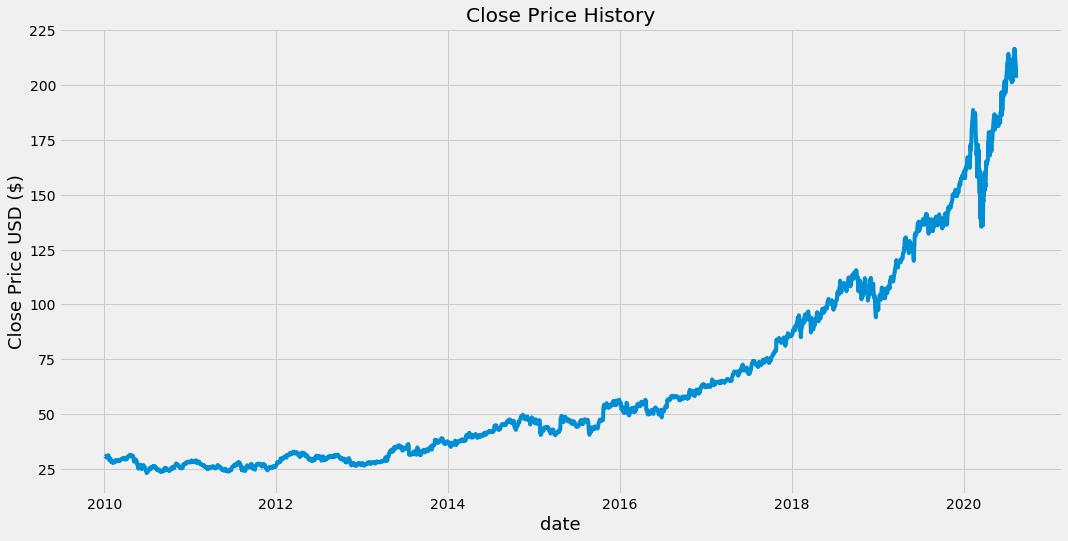

In [11]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])

plt.xlabel('date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [12]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 
data

,close
date,
2010-01-04,30.950
2010-01-05,30.960
2010-01-06,30.770
2010-01-07,30.452
2010-01-08,30.660
...,...
2020-08-05,212.940
2020-08-06,216.350
2020-08-07,212.480


In [13]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [14]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


In [15]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [17]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
2083/2083 [==============================] - 95s 46ms/step - loss: 1.9758e-04


In [20]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [21]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [22]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [24]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

5.404289717300327

C:\Users\Akhilesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


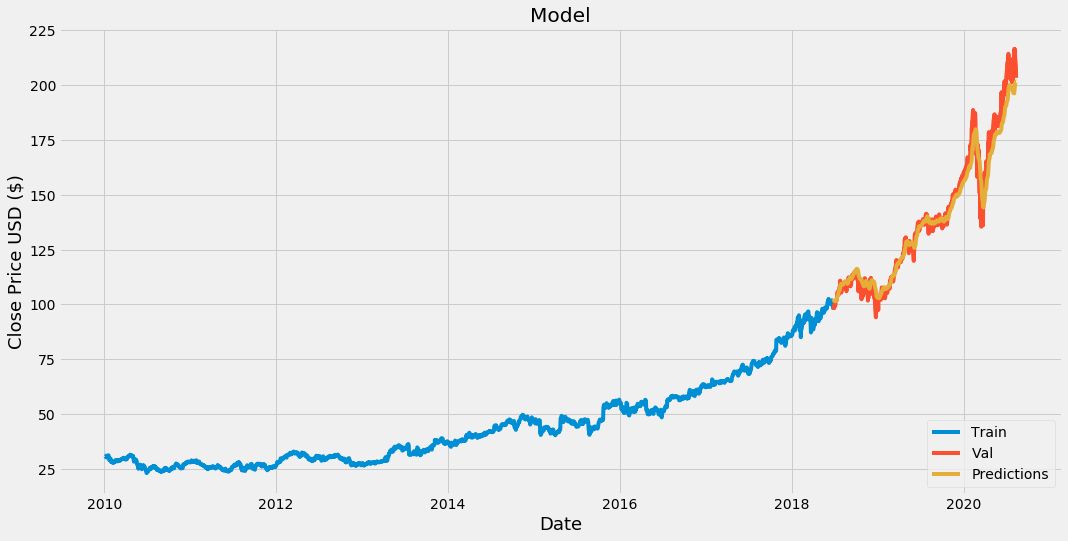

In [26]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [27]:
#Show the valid and predicted prices
valid

,close,Predictions
date,,
2018-06-27,97.54,102.459465
2018-06-28,98.63,102.013832
2018-06-29,98.61,101.684036
2018-07-02,100.01,101.439972
2018-07-03,99.05,101.420364
...,...,...
2020-08-05,212.94,198.770798
2020-08-06,216.35,199.821548
2020-08-07,212.48,201.018890


In [30]:
security_api = intrinio_sdk.SecurityApi()

identifier = 'MSFT' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = '2010-01-01' # date | Return prices on or after the date (optional)
end_date = '2020-08-11' # date | Return prices on or before the date (optional)
frequency = 'daily' # str | Return stock prices in the given frequency (optional) (default to daily)
page_size = 3000 # int | The number of results to return (optional) (default to 100)
next_page = '' # str | Gets the next page of data from a previous API call (optional)

try:
  api_response = security_api.get_security_stock_prices(identifier, start_date=start_date, end_date=end_date, frequency=frequency, page_size=page_size, next_page=next_page)
  #pprint(api_response)
except ApiException as e:
  print("Exception when calling SecurityApi->get_security_stock_prices: %s\r\n" % e)

df1 = pd.DataFrame(api_response.stock_prices_dict)
df1.sort_values(["date"], axis=0, 
                 ascending=True, inplace=True) 
df1.set_index('date',inplace=True)
df1.head()

,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,
2010-01-04,False,daily,30.65,31.10,30.59,30.950,38414185.0,23.992776,24.345035,23.945808,24.227615,38414185.0
2010-01-05,False,daily,30.87,31.10,30.64,30.960,49758862.0,24.164991,24.345035,23.984948,24.235443,49758862.0
2010-01-06,False,daily,30.88,31.08,30.52,30.770,58182332.0,24.172819,24.329379,23.891012,24.086711,58182332.0
2010-01-07,False,daily,30.61,30.70,30.19,30.452,50564285.0,23.961464,24.031916,23.632688,23.837782,50564285.0
2010-01-08,False,daily,30.27,30.88,30.24,30.660,51201289.0,23.695312,24.172819,23.671828,24.000604,51201289.0


In [31]:
#Create a new dataframe
new_df = df1.filter(['close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[200.90259]]


In [32]:
x_input=test_data[535:].reshape(1,-1) #Last 60 data as input 
x_input.shape

(1, 60)

In [33]:
temp_input=list(x_input) #Converting last 60 days data into list
temp_input=temp_input[0].tolist()


In [34]:
temp_input

[0.8365628067999793,
 0.8299488451402883,
 0.8404381749599545,
 0.8289154136309617,
 0.8293287862346923,
 0.8193045005942231,
 0.8205446184054151,
 0.8184260838112954,
 0.8279853252725675,
 0.8258151191029816,
 0.8365628067999793,
 0.8388880276959645,
 0.8262801632821785,
 0.8483955975817702,
 0.8543895003358654,
 0.8618302072030177,
 0.8982069963313183,
 0.8435901410634011,
 0.8511858626569525,
 0.8573864517129127,
 0.8813103911538264,
 0.8847723867100709,
 0.8955200744070687,
 0.8894745000775074,
 0.9174804939802615,
 0.9244044850927505,
 0.9033741538779517,
 0.9162920477445359,
 0.8955717459825351,
 0.9064744484059318,
 0.9326719371673643,
 0.9388208546478581,
 0.9468816204206066,
 0.9698237999276597,
 0.9571642639384076,
 0.9808298455019894,
 0.9885289102464735,
 0.9851702578411615,
 0.9510670180333799,
 0.9576809796930709,
 0.9560791608536144,
 0.934790471761484,
 0.9294166279129851,
 0.97447424171963,
 0.9597478427117242,
 0.9752493153516252,
 0.9276597943471295,
 0.9212525189893

In [35]:
# demonstrate prediction for next 7 days
from numpy import array

lst_output=[]
n_steps=60
i=0
while(i<7):
    
    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# Undo the scaling
print("\n\nAfter performing scalar inverse transform:\n")
scaler.inverse_transform(lst_output)

[0.91919905]
61
1 day output [[0.9127947]]
2 day output [[0.90558136]]
3 day output [[0.89819986]]
4 day output [[0.8909426]]
5 day output [[0.88393146]]
6 day output [[0.87720907]]


After performing scalar inverse transform:



array([[200.90259204],
       [199.66316007],
       [198.26715965],
       [196.83861819],
       [195.43411626],
       [194.07725507],
       [192.7762708 ]])